In [140]:
import numpy as np
import xobjects as xo
import xtrack as xt
import xpart as xp
import matplotlib.pyplot as plt
from pybt.tools.particles import *

In [141]:

## Generate a simple line
line = xt.Line(
    elements=[xt.Drift(length=2.),
              xt.Multipole(knl=[0, 1.], ksl=[0,0]),
              xt.Drift(length=1.),
              xt.Multipole(knl=[0, -1.], ksl=[0,0])],
    element_names=['drift_0', 'quad_0', 'drift_1', 'quad_1'])

## Attach a reference particle to the line (optional)
## (defines the reference mass, charge and energy)
line.particle_ref = xp.Particles(p0c=6500e9, #eV
                                 q0=1, mass0=xp.PROTON_MASS_EV)

## Choose a context
context = xo.ContextCpu()         # For CPU
# context = xo.ContextCupy()      # For CUDA GPUs
# context = xo.ContextPyopencl()  # For OpenCL GPUs

## Transfer lattice on context and compile tracking code
line.build_tracker(_context=context)

## Build particle object on context
n_part = 200
particles = xp.Particles(p0c=6500e9, #eV
                        q0=1, mass0=xp.PROTON_MASS_EV,
                        x=np.random.uniform(-1e-3, 1e-3, n_part),
                        px=np.random.uniform(-1e-5, 1e-5, n_part),
                        y=np.random.uniform(-2e-3, 2e-3, n_part),
                        py=np.random.uniform(-3e-5, 3e-5, n_part),
                        zeta=np.random.uniform(-1e-2, 1e-2, n_part),
                        delta=np.random.uniform(-1e-4, 1e-4, n_part),
                        _context=context)

## Track (saving turn-by-turn data)
n_turns = 100
line.track(particles, num_turns=n_turns,
              turn_by_turn_monitor=True)

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


ld: warning: -pie being ignored. It is only used when linking a main executable


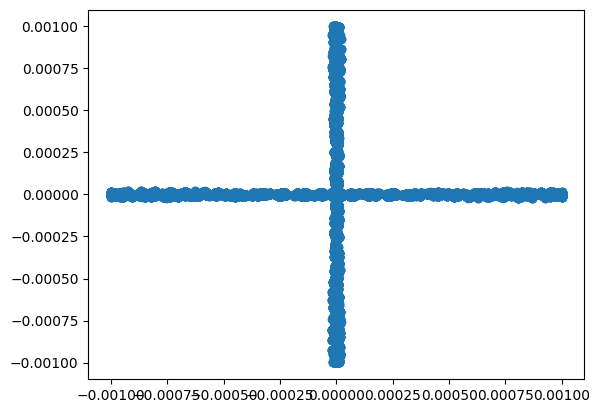

In [142]:
plt.scatter(line.record_last_track.x, line.record_last_track.px);

In [143]:
from cpymad.madx import Madx
import requests

In [144]:
# Beam characteristics
gamma = 25.598474067
beta = np.sqrt(1-gamma**(-2))
exn = 4.92e-06
eyn = 3.4e-06
sige = 0.000412
ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)
Brho = 24*3.3356

# Initial conditions
betx0 = 154.0835045206266
bety0 = 5.222566527078791
alfx0 = -36.90472944993891
alfy0 = 0.2523074897915478
Dx0 = 0.13
Dy0 = 0.0
Dpx0 = 0.02
Dpy0 = 0.0
exn = 7.639770207283603e-06
eyn =  3.534081877201574e-06
sige = 0.000679081344780741

In [145]:
madx = Madx()
madx.input(requests.get("https://gitlab.cern.ch/eljohnso/acc-models-tls-eliott-fork/-/raw/EliottBranch/ps_extraction/f61t8/f61t8_op.str").text)
madx.input(requests.get("https://gitlab.cern.ch/eljohnso/acc-models-tls-eliott-fork/-/raw/EliottBranch/ps_extraction/f61t8/f61t8_op.seq").text)

ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)

madx.command.beam(particle='PROTON',pc="24",exn=exn,eyn=eyn)
madx.input('BRHO      := BEAM->PC * 3.3356;')

madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L, DELTAP, BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APERTYPE,APER_1,APER_2,APER_3,APER_4,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')
madx.use(sequence="f61t8_op")

madx.use(sequence="f61t8_op")
madx.input('SEQEDIT, sequence=f61t8_op;')
madx.input('FLATTEN;')
madx.input('ENDEDIT;')
madx.use(sequence="f61t8_op")
madx.input("SELECT, FLAG=makethin, SLICE=5;")
madx.input("MAKETHIN, SEQUENCE=f61t8_op, style=TEAPOT")
madx.use(sequence="f61t8_op")

line = xt.Line.from_madx_sequence(madx.sequence.f61t8_op, install_apertures=False)


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.09.00  (64 bit, Darwin)      +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2023.05.05               +
  + Execution date: 2023.07.11 11:01:36      +
  ++++++++++++++++++++++++++++++++++++++++++++
++++++ info: element redefined: mbxhd
++++++ info: seqedit - number of elements installed:  0
++++++ info: seqedit - number of elements moved:      0
++++++ info: seqedit - number of elements removed:    0
++++++ info: seqedit - number of elements replaced:   0
makethin: style chosen : teapot
makethin: slicing sequence : f61t8_op
Converting sequence "f61t8_op": 83%     


In [146]:
# Defining a reference particle
line.particle_ref = xp.Particles(p0c=24e9, #eV
                                 q0=1, mass0=xp.PROTON_MASS_EV)

In [147]:
line.build_tracker()


Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.


In [181]:
tw_init = xt.TwissInit(element_name="f61.start",
    x=0, px=0, y=0, py=0, zeta=0, delta=0,
    betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0,
    dx=Dx0, dy=Dy0, dpx=Dpx0, dpy=Dpy0,
    mux=0, muy=0, muzeta=0, dzeta=0,
    bets=0, reference_frame="proper",
    particle_ref=line.particle_ref)

Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.


In [182]:
tw_test = line.twiss(ele_start="f61.start", ele_stop="t08.end", twiss_init=tw_init)

In [184]:
line.element_names

('f61t8_op$start',
 'f61.start',
 'drift_0',
 'q74',
 'drift_1',
 'f61.mqncl007..1',
 'drift_2',
 'f61.mqncl007..2',
 'drift_3',
 'f61.mqncl007',
 'f61.mqncl007..3',
 'drift_4',
 'f61.mqncl007..4',
 'drift_5',
 'f61.mqncl007..5',
 'drift_6',
 'f61.btv012',
 'drift_7',
 'f61.mcxce013..1',
 'drift_8',
 'f61.mcxce013..2',
 'drift_9',
 'f61.mcxce013',
 'f61.mcxce013..3',
 'drift_10',
 'f61.mcxce013..4',
 'drift_11',
 'f61.mcxce013..5',
 'drift_12',
 'f61.mqnel014..1',
 'drift_13',
 'f61.mqnel014..2',
 'drift_14',
 'f61.mqnel014',
 'f61.mqnel014..3',
 'drift_15',
 'f61.mqnel014..4',
 'drift_16',
 'f61.mqnel014..5',
 'drift_17',
 'f61.mcxce015..1',
 'drift_18',
 'f61.mcxce015..2',
 'drift_19',
 'f61.mcxce015',
 'f61.mcxce015..3',
 'drift_20',
 'f61.mcxce015..4',
 'drift_21',
 'f61.mcxce015..5',
 'drift_22',
 'f61.tbs016',
 'drift_23',
 'f61.tbs017',
 'drift_24',
 'f61.tbs018',
 'drift_25',
 'f61.tbs019',
 'drift_26',
 'f61.tbs020',
 'drift_27',
 'f61.mqnef021..1',
 'drift_28',
 'f61.mqnef021

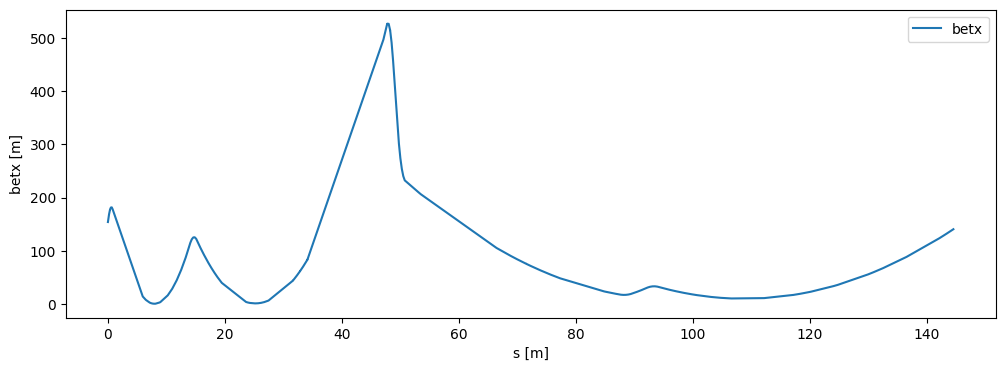

In [183]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(tw.s, tw.betx, label="betx")
ax.set_xlabel("s [m]")
ax.set_ylabel("betx [m]")
ax.legend()

In [ ]:
# Create a context (CPU)
import xobjects as xo
context = xo.ContextCpu()

In [ ]:
# Build the tracker
import xtrack as xt
line.build_tracker(_context=context)

Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.


In [ ]:
## Build particle object on context
n_part = 5000
n_sigma = 5
x, px = beam_distrib_norm(alfx0, betx0, ex, n_part, n_sigma).T
y, py = beam_distrib_norm(alfy0, bety0, ey, n_part, n_sigma).T
particles = xp.Particles(p0c=24e9, #eV
                        q0=1, mass0=xp.PROTON_MASS_EV,
                        x=x,
                        px=px,
                        y=y,
                        py=py,
                        zeta=np.random.uniform(0, 0, n_part),
                        delta=np.random.uniform(0, 0, n_part),
                        _context=context)

In [ ]:
# Track the particles
line.track(particles, turn_by_turn_monitor="ONE_TURN_EBE")

Text(0.5, 0.98, 'Tracking with xtrack 5000 particles')

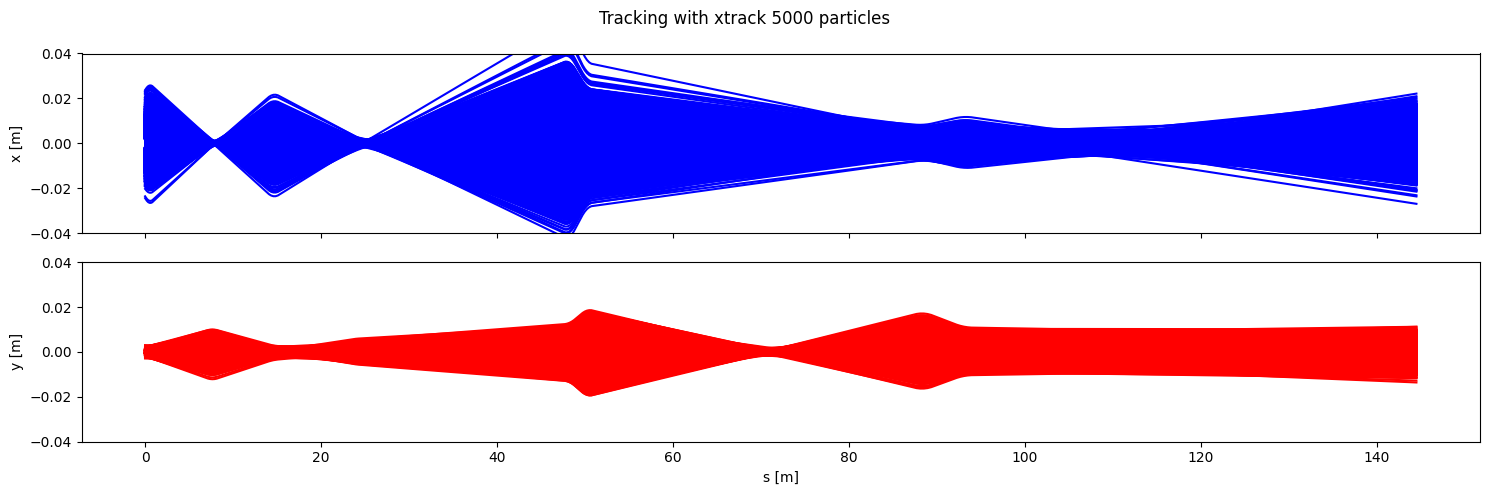

In [ ]:
fig,ax = plt.subplots(2,1, figsize=(15,5), tight_layout=True, sharex=True)

for i in range(len(line.record_last_track.s)):
    ax[0].plot(line.record_last_track.s[i], line.record_last_track.x[i], color='blue');
    ax[1].plot(line.record_last_track.s[i], line.record_last_track.y[i], color='red');

ax[0].set_ylabel('x [m]')
ax[1].set_xlabel('s [m]')
ax[1].set_ylabel('y [m]')

ax[0].set_ylim(-0.04, 0.04)
ax[1].set_ylim(-0.04, 0.04)

fig.suptitle(f'Tracking with xtrack {n_part} particles')

In [ ]:
df = particles.to_pandas()
df.keys()

Index(['start_tracking_at_element', 'q0', 'mass0', 's', 'zeta', 'chi',
       'charge_ratio', 'weight', 'particle_id', 'at_element', 'at_turn',
       'state', 'parent_particle_id', '_rng_s1', '_rng_s2', '_rng_s3',
       '_rng_s4', 'x', 'y', 'px', 'py', 'delta', 'ptau', 'rvv', 'rpp', 'p0c',
       'beta0', 'gamma0'],
      dtype='object')

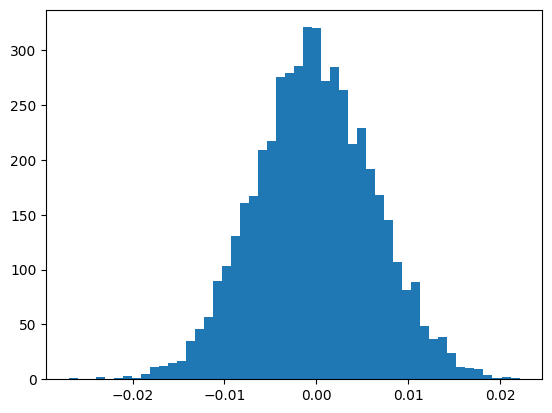

In [ ]:
particles_from_df = xp.Particles.from_pandas(df, _context=context)
plt.hist(particles_from_df.x, bins=50);